**This notebook is about**:
* Trying out the UK Open Data API
* Requesting data on corona virus from [GOV.UK Coronavirus(COVID-19) Open Data API](https://coronavirus.data.gov.uk/details/developers-guide/main-api)
* Doing some pretty quick and dirty data exploration
* Getting some simple statistics
* Visualising the results

In [1]:
from typing import Iterable, Dict, Union, List
import json
from requests import get
from http import HTTPStatus

In [2]:
StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

In [4]:
def get_paginated_dataset(filters: FiltersType, structure: StructureType, as_csv: bool = False) -> APIResponseType:
    '''
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.
        as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    '''
    endpoint = 'https://api.coronavirus.data.gov.uk/v1/data'
    
    api_params = {'filters': str.join(';', filters),
                  'structure': json.dumps(structure, separators = (',', ':')),
                  'format': 'json' if not as_csv else 'csv'
                 }
    data = list()
    page_number = 1
    while True:
        # add page number to query params
        api_params['page'] = page_number
        response = get(endpoint, params = api_params, timeout = 10)
        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break
        if as_csv:
            csv_content = response.content.decode()
            # Removing CSV header (column names) where page number is greater than 1
            if page_number > 1:
                data_lines = csv_content.split('\n')[1:]
                csv_content = str.join('\n', data_lines)
            data.append(csv_content.strip())
            page_number += 1
            continue
        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        data.extend(page_data)
        # The "next" attribute in "pagination" will be `None` when we reach the end
        if not current_data['pagination']['next']:
            break
        page_number += 1
    if not as_csv:
        return data
    # concatenating CSV pages
    return str.join('\n', data)

In [5]:
query_filters = [f'areaType=region']
query_structure = {"date": "date",
                   "name": "areaName",
                   "code": "areaCode",
                   "daily": "newCasesBySpecimenDate",
                   "cumulative": "cumCasesBySpecimenDate"
                  }

In [6]:
json_data = get_paginated_dataset(query_filters, query_structure)

In [7]:
print(f'Length: {len(json_data)}')
print(f'Data (first 3 items):\n{json_data[:3]}')
#print('---' * 10)

Length: 6509
Data (first 3 items):
[{'date': '2022-02-08', 'name': 'North East', 'code': 'E12000001', 'daily': 1274, 'cumulative': 810348}, {'date': '2022-02-07', 'name': 'North East', 'code': 'E12000001', 'daily': 2285, 'cumulative': 809074}, {'date': '2022-02-06', 'name': 'North East', 'code': 'E12000001', 'daily': 1871, 'cumulative': 806789}]


In [9]:
csv_data = get_paginated_dataset(query_filters, query_structure, as_csv = True)

In [10]:
csv_lines = csv_data.split("\n")
#print('CSV:')
print(f'Length: {len(csv_lines)}')
print(f'Data (first 3 lines):\n{csv_lines[:3]}')

Length: 6510
Data (first 3 lines):
['date,name,code,daily,cumulative', '2022-02-08,North East,E12000001,1274,810348', '2022-02-07,North East,E12000001,2285,809074']


**Save the data to disk**

In [16]:
import csv

In [15]:
with open('./data/data.json', 'wt') as f:
    json.dump(json_data, f)

In [21]:
# with open('./data/data.csv', 'wt') as f:
#     f_csv = csv.writer(f)
#     f_csv.writerows(csv_lines)

**Load and analyse data**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

**Read the data from disk and create a DataFrame**

In [3]:
df = pd.read_json('./data/data.json').set_index('date')
df.head()

,name,code,daily,cumulative
date,,,,
2022-02-08,North East,E12000001,1274,810348
2022-02-07,North East,E12000001,2285,809074
2022-02-06,North East,E12000001,1871,806789
2022-02-05,North East,E12000001,1629,804918
2022-02-04,North East,E12000001,2106,803289


In [4]:
print(df.shape)
print(type(df.index))

(6509, 4)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


**Create columns for year, month and day**

In [5]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df.head()

,name,code,daily,cumulative,year,month,day
date,,,,,,,
2022-02-08,North East,E12000001,1274,810348,2022,2,8
2022-02-07,North East,E12000001,2285,809074,2022,2,7
2022-02-06,North East,E12000001,1871,806789,2022,2,6
2022-02-05,North East,E12000001,1629,804918,2022,2,5
2022-02-04,North East,E12000001,2106,803289,2022,2,4


In [7]:
df.rename(columns = {'name': 'region'}, inplace = True)       # rename the column 'name' to 'region'
df.head()

,region,code,daily,cumulative,year,month,day
date,,,,,,,
2022-02-08,North East,E12000001,1274,810348,2022,2,8
2022-02-07,North East,E12000001,2285,809074,2022,2,7
2022-02-06,North East,E12000001,1871,806789,2022,2,6
2022-02-05,North East,E12000001,1629,804918,2022,2,5
2022-02-04,North East,E12000001,2106,803289,2022,2,4


In [21]:
print(df.code.nunique())
print(df.region.nunique())

9
9


**Regional Yearly Tally**

In [10]:
regional_yearly = df.groupby(['region', 'year'])['daily'].sum()
regional_yearly.head()

region           year
East Midlands    2020     196466
                 2021     824484
                 2022     308244
East of England  2020     216750
                 2021    1020818
Name: daily, dtype: int64

In [11]:
regional_yearly_df = pd.DataFrame(regional_yearly)
regional_yearly_df.head()

daily
region          year         
East Midlands   2020   196466
                2021   824484
                2022   308244
East of England 2020   216750
                2021  1020818

<AxesSubplot:xlabel='region,year'>

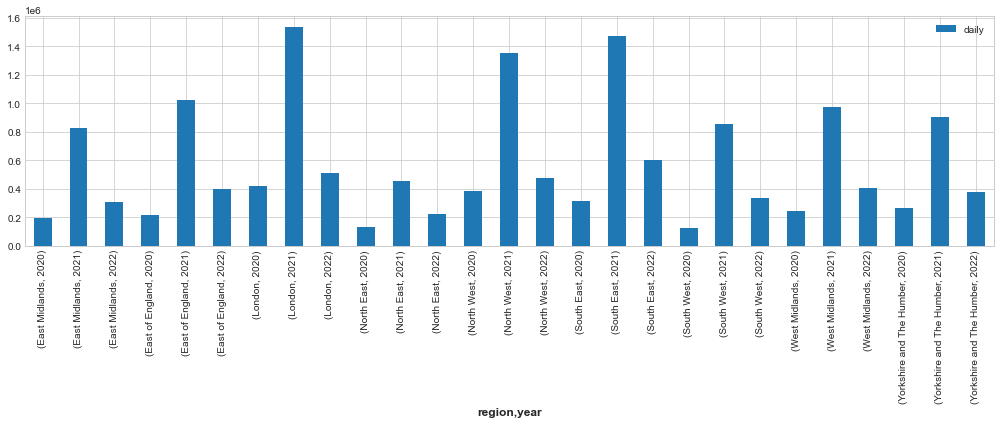

In [25]:
regional_yearly_df.plot(kind = 'bar', figsize = (14, 6))

The chart shows that: 
* **All regions were at peak period in 2021**
* The **least** affected region is **North East**
* There is a **general decline** in the number of cases in **Feb 2022**
#### Nation-wide monthly Tally

In [17]:
regional_monthly = df.groupby(['year', 'month'])['daily'].sum()
regional_monthly.head()

year  month
2020  1             1
      2            35
      3         31542
      4        112515
      5         66895
Name: daily, dtype: int64

In [18]:
regional_monthly_df = pd.DataFrame(regional_monthly)
regional_monthly_df.head()

daily
year month        
2020 1           1
     2          35
     3       31542
     4      112515
     5       66895

<AxesSubplot:xlabel='year,month'>

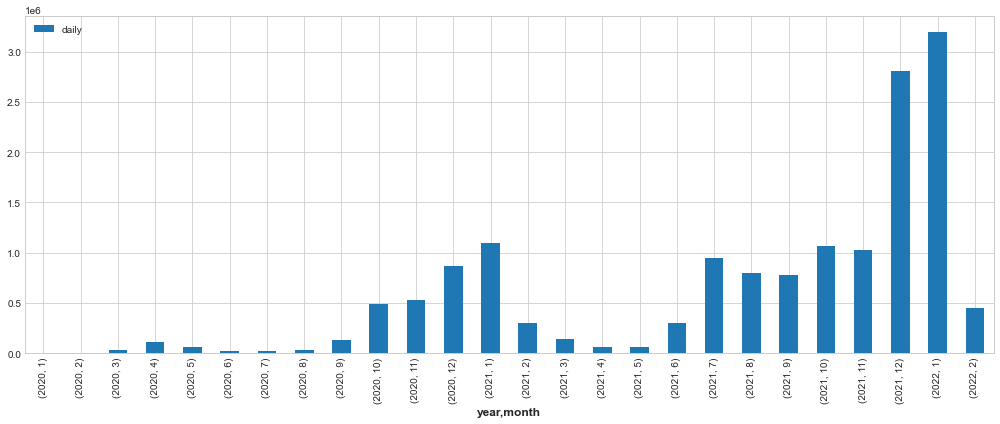

In [19]:
regional_monthly_df.plot(kind = 'bar', figsize = (14, 6))

The disproportionate high cases in **December 2021 - January 2022** is due to the outbreak of the **omicron** variant.
#### Daily Variation in the number of cases

<AxesSubplot:xlabel='date', ylabel='daily'>

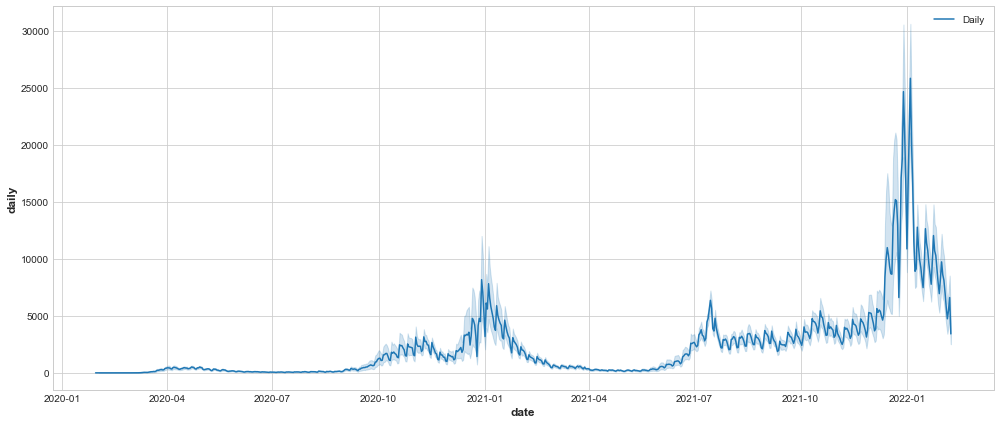

In [23]:
plt.figure(figsize = (14, 6))
sns.lineplot(data = df.daily, label = 'Daily')

**The daily statistics agrees with the monthly tally above with spikes in the periods `December - January` which saw the outbreak of `Delta`and `Omicron`variants respectively**. 

In [26]:
regional_yearly = df.groupby(['region', 'year'])['daily'].sum()
regional_yearly.head()

region           year
East Midlands    2020     196466
                 2021     824484
                 2022     308244
East of England  2020     216750
                 2021    1020818
Name: daily, dtype: int64

In [27]:
regional_yearly_df = pd.DataFrame(regional_yearly)
regional_yearly_df.head()

daily
region          year         
East Midlands   2020   196466
                2021   824484
                2022   308244
East of England 2020   216750
                2021  1020818

Text(0.5, 1.0, 'Yearly Tally by Region')

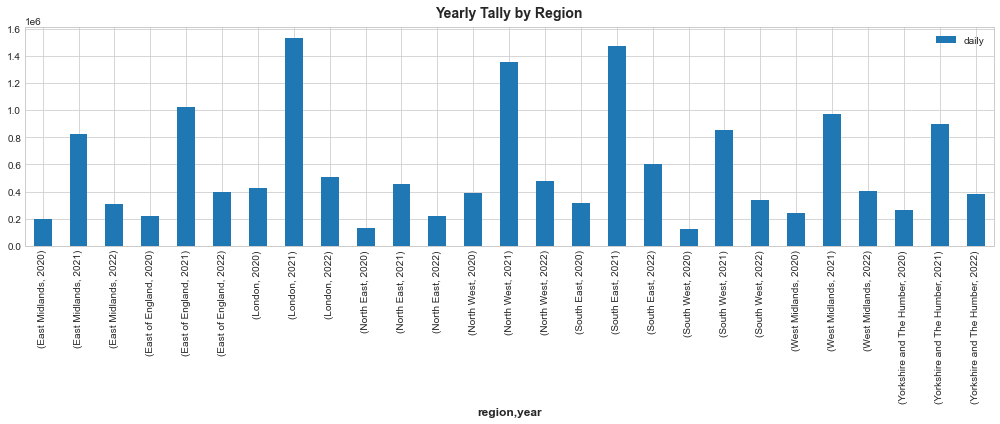

In [28]:
regional_yearly_df.plot(kind = 'bar', figsize = (14, 6))
plt.title('Yearly Tally by Region')